# Rydberg Gates

In this notebook, we explore using `GenStateChain` to perform Rydberg gates with a hyperfine encoding. We will also calculate fidelities.

We start by setting up two 3-level systems, where the bottom two states are hyperfine states, and the third state is the Rydberg state. 

In [1]:
import GenStateChain as GSC
import numpy as np
GSC.set_n([3,3])

Let's set up our microwave pulse Hamiltonian between states 0 and 1. 

In [2]:
def CreateMicrowaveHamiltonian(omega, delta, site_idxs):
    # Create the Rabi drive term and detuning term
    H = GSC.Operators.zero()
    
    for elem in site_idxs:
        H = H + omega / 2 * GSC.Operators.sigmax([elem], [[0,1]]) - delta * GSC.Operators.proj(GSC.create_state_list([elem],1)) # The delta multiplies a projector of state 1 on site i

    return H
site_idxs = [0, 1]
omega = 2 * np.pi * 1
delta = 0
HMicrowave = CreateMicrowaveHamiltonian(omega, delta, site_idxs)

We check our microwave pulse works.

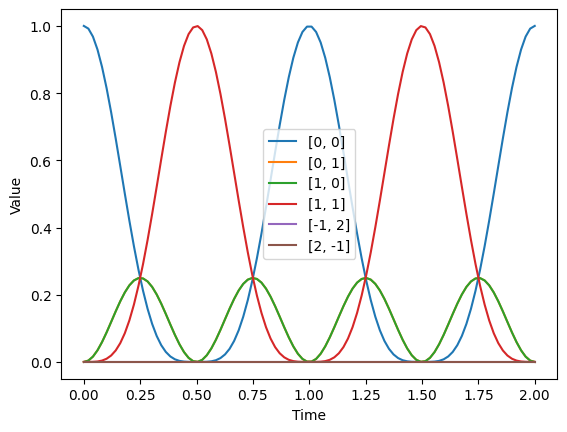

In [3]:
init_state = GSC.States.specify([0,0]) # start in ground state
tend = 2 * 2 * np.pi/omega
npts = 100
expects = [[0,0], [0,1], [1,0], [1,1], [-1,2], [2,-1]]# expectation values to calculate. Here, just projectors into each state. By default, a list is interpretted as a projector. You can also put in full fledged operators.
bPlot = 1
result = GSC.Dynamics.Unitary(HMicrowave, init_state, tend, npts, expects, 1)

Now, we make our site selective Rydberg excitation, and check the blockade effect. Notice that both hyperfine states can couple to the Rydberg state, but one state will be far detuned. 

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.67341057e-04+6.05240087e-05j]
 [ 9.95057198e-01+9.87549169e-02j]
 [-2.73677794e-03+1.00557567e-02j]]

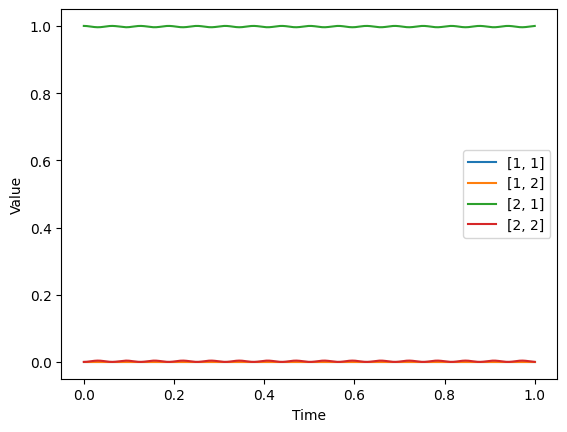

In [4]:
def CreateDrivenRydHamiltonian(coords, omega, delta, C6, EHFS, site_idxs):
    # Create the Rabi drive term and detuning term
    H = GSC.Operators.zero()
    
    for elem in site_idxs:
        H = H + omega / 2 * GSC.Operators.sigmax([elem], [[1,2]]) - delta * GSC.Operators.proj(GSC.create_state_list([elem],2)) + \
            omega / 2 * GSC.Operators.sigmax([elem], [[0,2]]) - EHFS * GSC.Operators.proj(GSC.create_state_list([elem], 0))  # The delta multiplies a projector of state 1 on site i
    
    # Lastly we add the interaction term. Here we use an operator from the library.
    states = 2 # The interacting state is state 1. 
    H = H + GSC.Operators.PairInteraction(coords, C6, states)
    return H

coords = [[0,0],[1,0]] # two sites, 1 unit apart
omegaRyd = 2 * np.pi * 1
deltaRyd = 0
C6 = 100
site_idxs = [1] # drive on site 1
EHFS = - 2 * np.pi * 9192 # hyperfine structure on Cs

HRyd = CreateDrivenRydHamiltonian(coords, omegaRyd, deltaRyd, C6, EHFS, site_idxs)

init_state = GSC.States.specify([2,1]) # start with site 0 already in Rydberg state
tend = 1 * 2 * np.pi/omega
npts = 300
expects = [[1,1], [1,2], [2,1], [2,2]]# expectation values to calculate. Here, just projectors into each state. By default, a list is interpretted as a projector. You can also put in full fledged operators.
bPlot = 1
result = GSC.Dynamics.Unitary(HRyd, init_state, tend, npts, expects, 1)
result.final_state

If the C6 coefficient is turned off, then we should get a Rabi oscillation and a pi phase shift.

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-9.66246696e-09+8.51574035e-09j]
 [-9.99999996e-01-8.54436644e-05j]
 [-1.52744010e-13-4.36332237e-09j]]

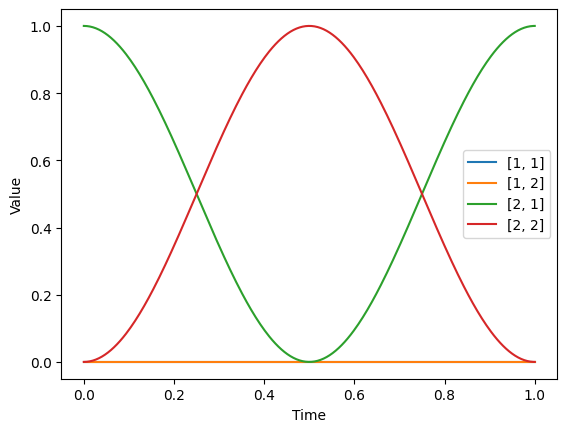

In [5]:
coords = [[0,0],[1,0]] # two sites, 1 unit apart
omegaRyd = 2 * np.pi * 1
deltaRyd = 0
C6 = 0
site_idxs = [1] # drive on site 1
EHFS = - 2 * np.pi * 9192 # hyperfine structure on Cs

HRyd = CreateDrivenRydHamiltonian(coords, omegaRyd, deltaRyd, C6, EHFS, site_idxs)

init_state = GSC.States.specify([2,1]) # start with site 0 already in Rydberg state
tend = 1 * 2 * np.pi/omega
npts = 300
expects = [[1,1], [1,2], [2,1], [2,2]]# expectation values to calculate. Here, just projectors into each state. By default, a list is interpretted as a projector. You can also put in full fledged operators.
bPlot = 1
result = GSC.Dynamics.Unitary(HRyd, init_state, tend, npts, expects, 1)
result.final_state

Now, we can put a pulse sequence together and measure some fidelities. We need to create a function which takes in a state and returns a final state after evolution. This is the input to `GenStateChain.CalculateFidelity`.

In [6]:
def OrigRydCZGate(coords, omegas, deltas, C6, EHFS):
    def func(init_state):
        HRyd0 = CreateDrivenRydHamiltonian(coords, omegas[0], deltas[0], C6, EHFS[0], [0])
        result = GSC.Dynamics.Unitary(HRyd0, init_state, np.pi/omegas[0], 100) # pick tend so it's a pi pulse
        HRyd1 = CreateDrivenRydHamiltonian(coords, omegas[1], deltas[1], C6, EHFS[1], [1])
        result = GSC.Dynamics.Unitary(HRyd1, result.final_state, 2 * np.pi/omegas[1], 1000) # pick tend so it's a 2 pi pulse
        result = GSC.Dynamics.Unitary(HRyd0, result.final_state, np.pi/omegas[0], 1000) # pi pulse back on the original atom.
        return result.final_state
    return func

We now form the target gate with `GenStateChain.Operators.cGate`. The first argument specifies the role of each bit, where a number over 1 indicates that state being the control state, -1 indicates that particular atom does not play a role in the gate, and a -2 indicates it is a target atom.

In [7]:
gate = GSC.Operators.cGate([1,-2], GSC.Operators.sigmaz([1], [[0,1]], bSingle = 1))
gate = GSC.Operators.sigmaz([0,1], [[0,1], [0,1]]) * gate

Now, we use `GenStateChain.CalculateFidelity` to get the fidelity. It returns the resulting matrix and the calculated target matrix as its final two arguments. We specify the final argument `states` as the states of each chain to calculate the fidelity over.

In [8]:
coords = [[0,0], [1,0]]
omegas = [2 * np.pi, 2 * np.pi]
deltas = [0,0]
C6 = 100
EHFS = [-2 * np.pi * 1772, -2 * np.pi * 9192]
func = OrigRydCZGate(coords, omegas, deltas, C6, EHFS)
fidelity, op, target_op = GSC.CalculateFidelity(func, gate, states = [[0,1], [0,1]])
print(fidelity)

(0.9969748998636518+0.021670761107421468j)
